In [1]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.UNetEx import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [4]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
bin_channel = torch.isnan(x[:, 2:, :, :]).type(torch.float)
x = torch.cat([x, bin_channel], dim=1)
print(torch.sum(bin_channel))

tensor(467592.)


In [5]:
# Removing NaN values
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0

In [6]:
# Computing Root Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.1156]],

         [[0.0173]],

         [[0.0135]]]], device='cuda:0')


In [7]:
print(x.shape)
print(y.shape)

torch.Size([961, 4, 172, 79])
torch.Size([961, 3, 172, 79])


In [8]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [9]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [10]:
# Creating model
model = UNetEx(4, 3, filters=[8,16,32,32], kernel_size=5,
                    batch_norm=False, weight_norm=False)
model

UNetEx(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
    )
    (3): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padd

In [11]:
# Initializing weights
# initialize(model)

In [12]:
# Initializing optimizer
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [13]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = ((output - y) ** 2) / features_mse
    return torch.sum(loss), output

In [14]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [15]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [16]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18) 
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18) 
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[0,1,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,2,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [17]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 37392976.1875
	Train Total MSE = 1118.0838811965216
	Train Ux MSE = 340.2238115583147
	Train Uy MSE = 309.70330628894624
	Train p MSE = 468.15677969796315
	Validation Loss = 4575810.25390625
	Validation Total MSE = 417.2310981090506
	Validation Ux MSE = 210.48640394375812
	Validation Uy MSE = 81.98434411283183
	Validation p MSE = 124.76035084443934
Model saved!
Epoch #2
	Train Loss = 4507704.1953125
	Train Total MSE = 193.99670918782553
	Train Ux MSE = 107.8805175054641
	Train Uy MSE = 37.89446776253836
	Train p MSE = 48.22172428312756
	Validation Loss = 1178919.5
	Validation Total MSE = 119.95959895044875
	Validation Ux MSE = 67.53458861248716
	Validation Uy MSE = 24.29950970184432
	Validation p MSE = 28.12550306485186
Model saved!
Epoch #3
	Train Loss = 2327729.96875
	Train Total MSE = 107.58594367617653
	Train Ux MSE = 63.41166487194243
	Train Uy MSE = 22.269742874872115
	Train p MSE = 21.904536201840354
	Validation Loss = 911014.20703125
	Validation Total MSE

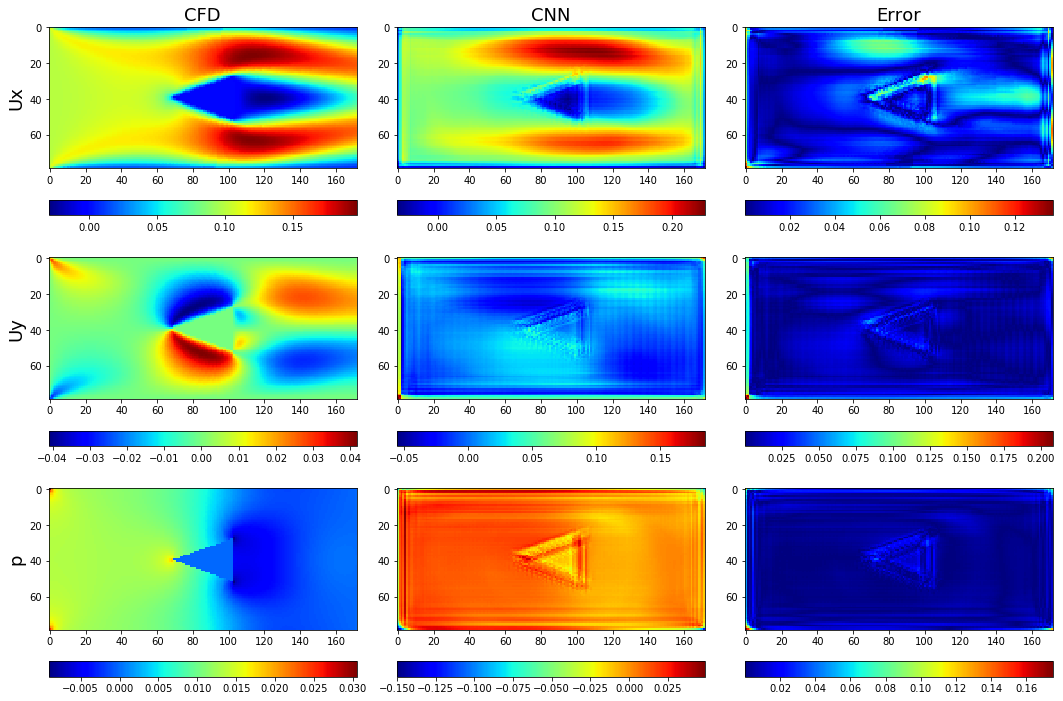

Epoch #11
	Train Loss = 331285.7119140625
	Train Total MSE = 15.998348281497048
	Train Ux MSE = 9.441756339300246
	Train Uy MSE = 4.59957910719372
	Train p MSE = 1.9570128577096122
	Validation Loss = 160159.794921875
	Validation Total MSE = 16.123160286345698
	Validation Ux MSE = 8.702383971956774
	Validation Uy MSE = 4.3967175863193395
	Validation p MSE = 3.0240585960731377
Model saved!
Epoch #12
	Train Loss = 299215.380859375
	Train Total MSE = 13.735261690048944
	Train Ux MSE = 7.711504277728853
	Train Uy MSE = 4.185433194750831
	Train p MSE = 1.8383241664795649
	Validation Loss = 150156.0673828125
	Validation Total MSE = 14.652994439676146
	Validation Ux MSE = 7.606058826908521
	Validation Uy MSE = 4.236095507664664
	Validation p MSE = 2.8108400787036723
Model saved!
Epoch #13
	Train Loss = 257954.41796875
	Train Total MSE = 11.78406742640904
	Train Ux MSE = 6.589824086143857
	Train Uy MSE = 3.5829425198691234
	Train p MSE = 1.6113010474613734
	Validation Loss = 131842.376953125
	V

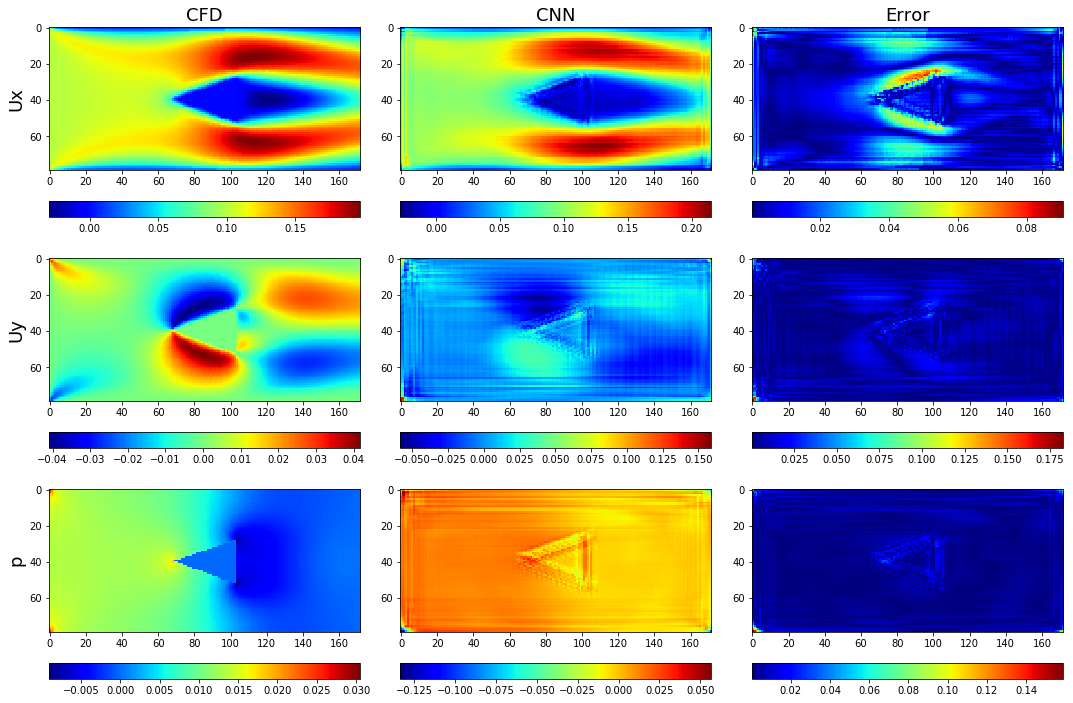

Epoch #21
	Train Loss = 136847.25439453125
	Train Total MSE = 6.356545312064035
	Train Ux MSE = 3.725697154090518
	Train Uy MSE = 1.460172102564857
	Train p MSE = 1.1706760639236087
	Validation Loss = 84401.52197265625
	Validation Total MSE = 7.838625634005325
	Validation Ux MSE = 4.037640053508191
	Validation Uy MSE = 1.537394210129048
	Validation p MSE = 2.2635915122642647
Model saved!
Epoch #22
	Train Loss = 131684.10986328125
	Train Total MSE = 6.212687378837948
	Train Ux MSE = 3.7010791982923235
	Train Uy MSE = 1.3759033396130516
	Train p MSE = 1.1357048395134153
	Validation Loss = 82646.81567382812
	Validation Total MSE = 7.761081207169793
	Validation Ux MSE = 4.054482562319218
	Validation Uy MSE = 1.4890716183144328
	Validation p MSE = 2.217527026536143
Model saved!
Epoch #23
	Train Loss = 127035.01806640625
	Train Total MSE = 5.971453485034761
	Train Ux MSE = 3.5480417069934664
	Train Uy MSE = 1.3177666891188848
	Train p MSE = 1.1056451329163142
	Validation Loss = 79734.5910644

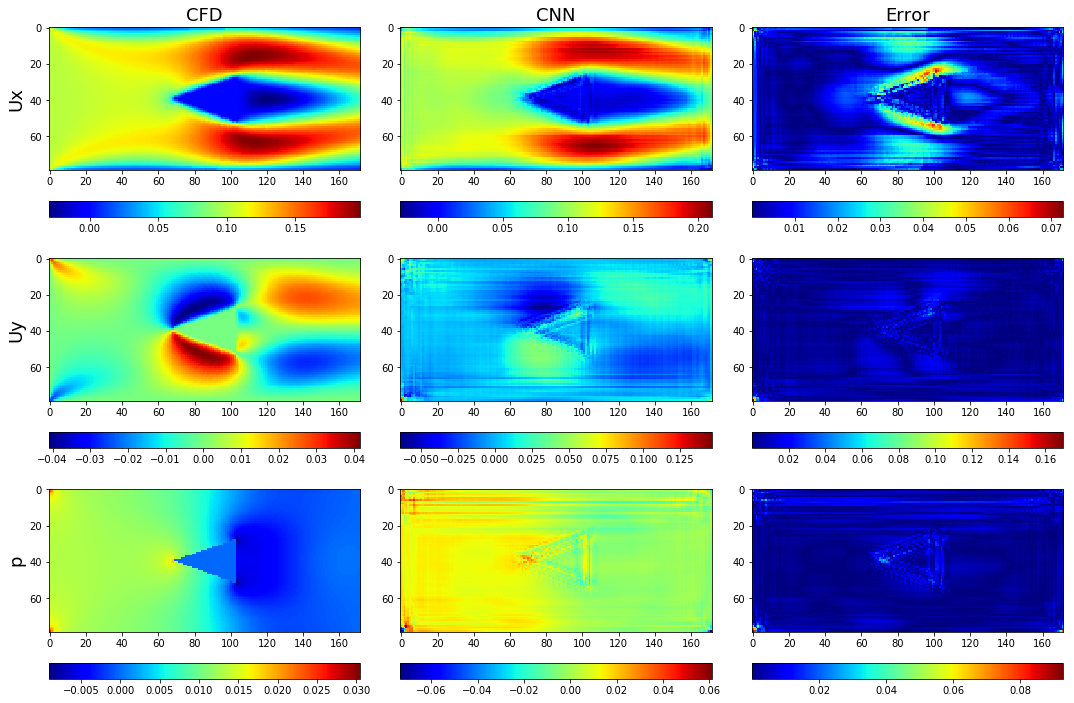

Epoch #31
	Train Loss = 110436.23510742188
	Train Total MSE = 5.110394897915068
	Train Ux MSE = 3.0137790611812045
	Train Uy MSE = 1.063024367604937
	Train p MSE = 1.0335914123625982
	Validation Loss = 72667.68188476562
	Validation Total MSE = 6.626446681039144
	Validation Ux MSE = 3.3815718126132
	Validation Uy MSE = 1.1496828600609592
	Validation p MSE = 2.095192226159119
Model saved!
Epoch #32
	Train Loss = 113934.99780273438
	Train Total MSE = 5.305386089143299
	Train Ux MSE = 3.1531808830442882
	Train Uy MSE = 1.0709706800324577
	Train p MSE = 1.0812346027010964
	Validation Loss = 79089.04931640625
	Validation Total MSE = 7.252566829272207
	Validation Ux MSE = 3.742341539851522
	Validation Uy MSE = 1.1875355730419752
	Validation p MSE = 2.3226894589856424
Epoch #33


KeyboardInterrupt: 

In [18]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer,
           epochs=10000, batch_size=32, device=device, after_epoch=after_epoch,
           m_mse_name="Total MSE",
           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
           m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_ux_name="Ux MSE",
           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
           m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_uy_name="Uy MSE",
           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
           m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_p_name="p MSE",
           m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
           m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           )